In [47]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
mpl.rcParams["font.family"] = "serif"
import seaborn as sns
import os
import datetime as dt
# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [31]:
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
import joblib

In [27]:
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
meso = [read_merged("mesocyclone", year) for year in range(2015, 2024)]
data = pd.concat(meso)
del data['Unnamed: 0']
del data['index']
del data['Event Month']
del data['Month']
data['TVS_max'] = 1*(data['TVS_max'] == 'Y')
data['DATE'] = pd.to_datetime(data['DATE'])
data['MONTH'] = data['DATE'].dt.month

/tmp/ipykernel_37278/979683209.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_37278/979683209.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_37278/979683209.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_37278/979683209.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))
/tmp/ipykernel_37278/979683209.py:2: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  retu

In [26]:
data

,DATE,LAT,LON,STR_RANK_max,LL_ROT_VEL,LL_DV,LL_BASE_max,DEPTH_KFT_max,DPTH_STMRL,MAX_RV_KFT_max,MAX_RV_KTS,TVS,MSI,COUNTY,STATE,MONTH,POWER_OUTAGE,Event Month
0,2015-01-01,36.16784,-85.894180,5,32,59,3,11,0,5,35,0,3488,Smith County,Tennessee,NaN,False,NaN
1,2015-01-01,33.12852,-96.287560,4,30,55,7,11,0,7,30,0,3060,Collin County,Texas,NaN,False,NaN
2,2015-01-01,33.29931,-96.047930,5,30,60,10,14,0,20,30,0,2880,Hunt County,Texas,NaN,False,NaN
3,2015-01-01,33.09212,-97.571860,4,32,56,7,11,0,7,32,0,2988,Wise County,Texas,NaN,False,NaN
4,2015-01-01,33.27608,-96.291220,4,30,56,15,11,0,15,30,0,2259,Fannin County,Texas,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699142,2023-12-31,35.33295,-94.274680,4L,29,28,1,1,100,1,31,0,3267,Sebastian County,Arkansas,NaN,False,NaN
699143,2023-12-31,35.36780,-94.438960,4L,34,42,0,1,100,0,34,0,2901,Le Flore County,Oklahoma,NaN,False,NaN
699144,2023-12-31,35.35267,-94.312715,4L,33,48,1,1,100,1,33,0,3586,Sebastian County,Arkansas,NaN,False,NaN
699145,2023-12-31,35.25208,-94.271330,4L,30,37,0,1,100,0,30,0,2825,Sebastian County,Arkansas,NaN,False,NaN


In [40]:
newnames = {'LAT_mean':'LAT', 'LON_mean':'LON', 'LL_ROT_VEL_max':'LL_ROT_VEL', 'DPTH_STMRL_max':'DPTH_STMRL', 
            'LL_BASE_max':'LL_BASE', 'DEPTH_KFT_max':'DEPTH_KFT', 'MAX_RV_KFT_max':'MAX_RV_KFT',
            'LL_DV_max':'LL_DV', 'DPTH_STMRL_max':'DPTH_STMRL', 'MAX_RV_KTS_max':'MAX_RV_KTS', 'TVS_max':'TVS', 'MSI_max':'MSI',
           'county':'COUNTY', 'state':'STATE', 'power_outage':'POWER_OUTAGE'}
data = data.rename(columns=newnames)


In [41]:
meso_train, meso_test = train_test_split(data, test_size=0.2, stratify=data.POWER_OUTAGE)
meso_tt, meso_val = train_test_split(meso_train, test_size=0.2, stratify=meso_train.POWER_OUTAGE)
outage = meso_tt[meso_tt['POWER_OUTAGE']==True]
no_outage = meso_tt[meso_tt['POWER_OUTAGE']==False]
no_outage= no_outage.sample(n=len(outage), random_state=101)
balanced = pd.concat([outage,no_outage],axis=0)

In [ ]:
xgb = joblib.load('../models/xgb_tornado.pkl')

In [10]:
xgb_clf = xgboost.XGBClassifier(objective= 'binary:logistic', learning_rate=0.01, max_depth=16, n_estimators=440)
rf_clf =  RandomForestClassifier(n_estimators=300, max_depth=13)
xgb_model = Pipeline([('resampler', RandomUnderSampler()), ('clf',xgb_clf)])
rf_model = Pipeline([('resampler', RandomUnderSampler()), ('clf', rf_clf)])
logistic_model = Pipeline([('resampler', RandomUnderSampler()), ('scaler',StandardScaler()), ('logistic', LogisticRegression(C=0.1))])


In [20]:
balanced.columns

Index(['DATE', 'LAT', 'LON', 'STR_RANK_max', 'LL_ROT_VEL', 'LL_DV',
       'LL_BASE_max', 'DEPTH_KFT_max', 'DPTH_STMRL', 'MAX_RV_KFT_max',
       'MAX_RV_KTS', 'TVS', 'MSI', 'COUNTY', 'STATE', 'MONTH', 'POWER_OUTAGE',
       'Event Month'],
      dtype='object')

In [22]:
features_n = ['MONTH', 'LAT', 'LON', 'LL_ROT_VEL', 'LL_DV', 'LL_BASE', 'DEPTH_KFT', 'DPTH_STMRL',
            'MAX_RV_KFT', 'MAX_RV_KTS', 'TVS', 'MSI']
features = ['LAT', 'LON', 'LL_ROT_VEL',
       'LL_DV', 'DPTH_STMRL', 'MAX_RV_KTS', 'TVS', 'MSI','MONTH']

### If not saved

In [13]:
models = {'xgboost_y': xgb_model, 'RandomForest_m': rf_clf, 'LogisticRegression': logistic_model}
for name, model in models.items():
    model.fit(balanced[features], balanced['POWER_OUTAGE'])
    joblib.dump(model,'../models/{}_meso_m.pkl'.format(name))
    

## Once saved

In [35]:
xgb = joblib.load('../models/xgb_meso.pkl')
rf = joblib.load('../models/rf_meso.pkl')
xgb_y = joblib.load('../models/xgboost_meso_y.pkl')
logistic = joblib.load('../models/LogisticRegression_meso_m.pkl')
rf_m = joblib.load('../models/RandomForest_m_meso_m.pkl')

In [36]:
models = {'xgboost':xgb, 'RandomForest':rf, 'xgboost_yuba': xgb_y,'RandomForest_monalisa': rf_m, 'LogisticRegression': logistic_model}

In [37]:
precisions, recalls, predictions ={}, {}, {}

In [43]:
for name, model in models.items():
    if name == 'xgboost_yuba' or name == 'RandomForest_monalisa' or name == 'LogisticRegression':
        preds = model.predict(meso_val[features])
        predictions[name] = preds
        recalls[name] = recall_score(meso_val['POWER_OUTAGE'], preds)
        precisions[name] = precision_score(meso_val['POWER_OUTAGE'], preds)
        
    else:
        preds = model.predict(meso_val[features_n])
        predictions[name] = preds
        precisions[name] = precision_score(meso_val['POWER_OUTAGE'], preds)
        recalls[name] = recall_score(meso_val['POWER_OUTAGE'], preds)



In [44]:
for name in models:
    print(f"Precision for {name} is {precisions[name]}")
    print(f"Recall for {name} is {recalls[name]}")

Precision for xgboost is 0.15737425620653736
Recall for xgboost is 0.9345621196564073
Precision for RandomForest is 0.11964844845115331
Recall for RandomForest is 0.8871052565675791
Precision for xgboost_yuba is 0.145295964647052
Recall for xgboost_yuba is 0.9386692043775513
Precision for RandomForest_monalisa is 0.11650627831240562
Recall for RandomForest_monalisa is 0.8753099095940498
Precision for LogisticRegression is 0.06381880566669883
Recall for LogisticRegression is 0.7122035511256918


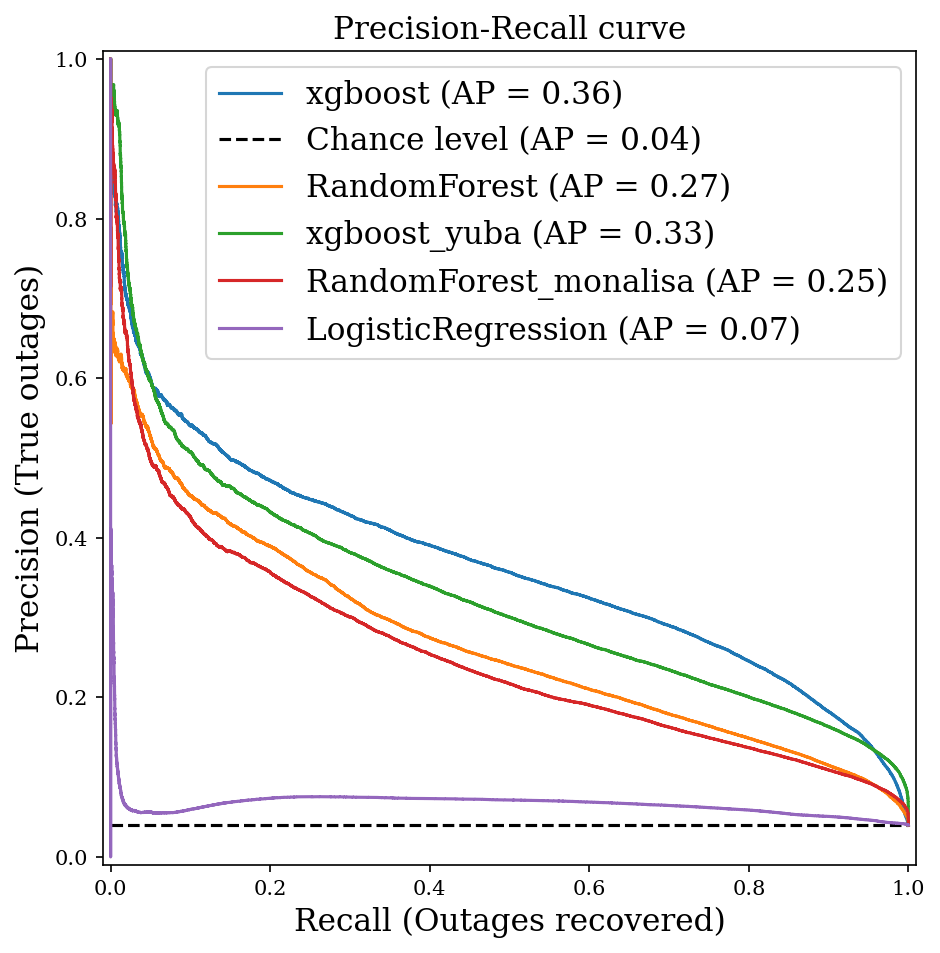

In [60]:
from sklearn.metrics import PrecisionRecallDisplay
fig, ax = plt.subplots(figsize=(7, 8))
for name, model in models.items():
    if name == 'xgboost_yuba' or name == 'RandomForest_monalisa' or name == 'LogisticRegression':
        display = PrecisionRecallDisplay.from_estimator(
        model, meso_val[features], meso_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=ax, name=name)
    else:
        display = PrecisionRecallDisplay.from_estimator(
        model, meso_val[features_n], meso_val['POWER_OUTAGE'], 
            plot_chance_level=name=='xgboost', ax=ax, name=name)
_ = display.ax_.set_title("Precision-Recall curve", size=15)      
_ = display.ax_.legend(loc='upper right', fontsize=15)      
_ = display.ax_.set_xlabel('Recall (Outages recovered)', size=15)      
_ = display.ax_.set_ylabel('Precision (True outages)', size=15)      

plt.savefig("meso_results.png", dpi=500, bbox_inches='tight',
            facecolor='white', transparent=False)
     


# Feature importance

In [51]:
best_model = models['xgboost']
best_model['clf'].get_booster().get_score(importance_type='gain')

{'MONTH': 9.598761558532715,
 'LAT': 4.91466760635376,
 'LON': 6.120001792907715,
 'LL_ROT_VEL': 1.3170994520187378,
 'LL_DV': 1.3261052370071411,
 'LL_BASE': 1.723360300064087,
 'DEPTH_KFT': 2.047816514968872,
 'DPTH_STMRL': 2.5881826877593994,
 'MAX_RV_KFT': 1.4650135040283203,
 'MAX_RV_KTS': 1.4653786420822144,
 'TVS': 2.439661741256714,
 'MSI': 1.4297455549240112}

# Confusion Matrix

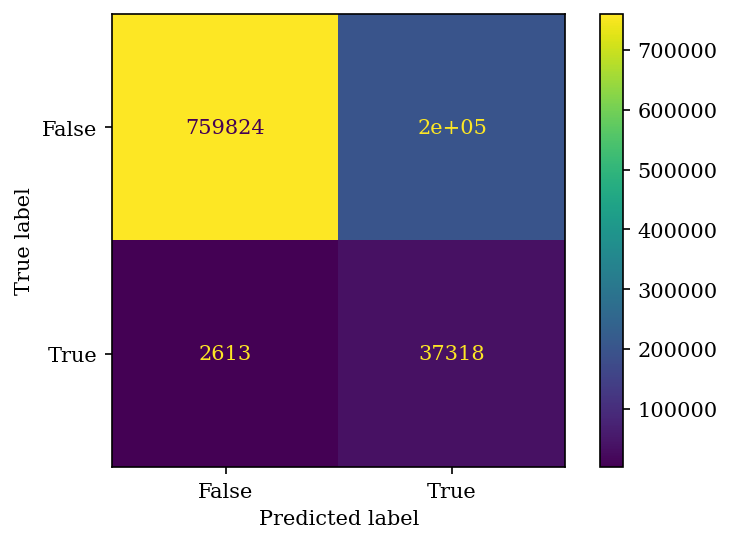

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(meso_val['POWER_OUTAGE'], predictions['xgboost'])

# Confusion matrix with a different threshold

In [57]:
probas = best_model.predict_proba(meso_val[features_n])

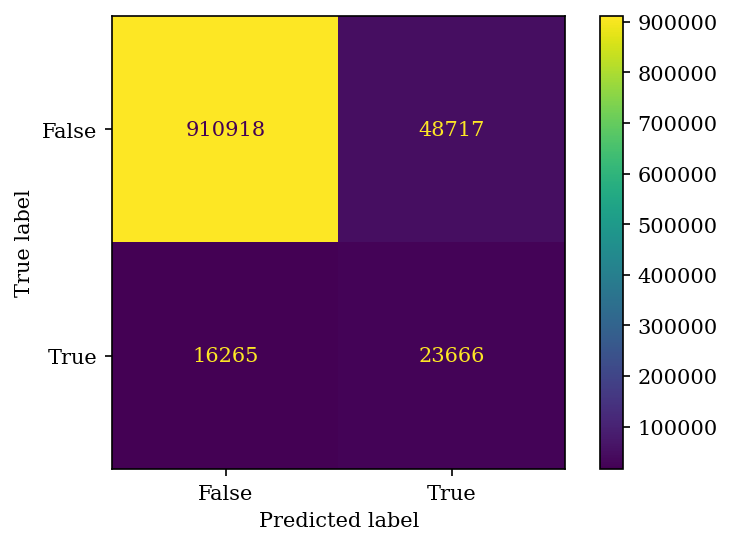

In [59]:
thr = 0.9
ConfusionMatrixDisplay.from_predictions(meso_val['POWER_OUTAGE'], probas[:,1]>thr)